## Exporting the data

In [1]:
import pandas as pd

In [66]:
amazon_data = pd.read_csv("AMZN.csv")
amazon_data.shape

(1762, 7)

In [67]:
import datetime
#to convert the datatype of date into datetime
def str_to_date(s):
    split=s.split("-")
    year,month,day=int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=year,month=month,day=day)

In [68]:
amazon_data['Date'] = amazon_data['Date'].apply(str_to_date)

In [69]:
amazon_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-06-13,35.700500,36.099499,35.557999,35.762001,35.762001,67044000
1,2016-06-14,35.616501,36.040501,35.613499,35.965000,35.965000,50138000
2,2016-06-15,36.099998,36.127998,35.667500,35.713001,35.713001,54188000
3,2016-06-16,35.602501,35.900002,35.264999,35.875500,35.875500,61960000
4,2016-06-17,35.909500,35.910000,34.959000,35.319500,35.319500,117956000
...,...,...,...,...,...,...,...
1757,2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
1758,2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
1759,2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300
1760,2023-06-09,124.080002,125.800003,123.190002,123.430000,123.430000,51330000


In [70]:
amazon_data.set_index('Date',inplace=True)

In [71]:
amazon_data=amazon_data[['Open']]

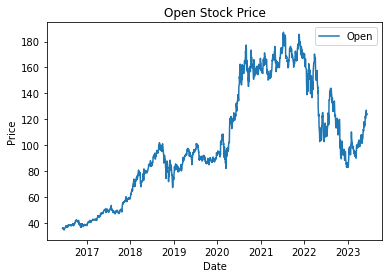

In [127]:
import matplotlib.pyplot as plt
plt.plot(amazon_data.index,amazon_data['Open'],label='Open')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Open Stock Price")
plt.legend()
plt.show()

In [73]:
amazon_data

,Open
Date,
2016-06-13,35.700500
2016-06-14,35.616501
2016-06-15,36.099998
2016-06-16,35.602501
2016-06-17,35.909500
...,...
2023-06-06,125.070000
2023-06-07,127.010002
2023-06-08,123.010002


## Scaling the data

In [74]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler(feature_range=(0,1))
amazon_data1=ms.fit_transform(np.array(amazon_data).reshape(-1,1))      # or
# amazon_data[amazon_data.columns] = ms.fit_transform(amazon_data)

In [75]:
amazon_data1.shape

(1762, 1)

## Splitting the data

In [77]:
training_size = int(len(amazon_data1)*0.70)
train_data = amazon_data1[:training_size]
test_data = amazon_data1[training_size:]
len(train_data),len(test_data)

(1233, 529)

In [78]:
timestep = 80
def create_dataset(dataset,timestep):
    x = []
    y = []
    for i in range(len(dataset)-timestep-1):
        x.append(dataset[i:i+timestep,0])
        y.append(dataset[i+timestep,0])
    return np.array(x), np.array(y)

**We can also use TimeseriesGenerator for splitting the data**

In [13]:
# import tensorflow as tf
# from tf.keras.preprocessing.sequence import TimeseriesGenerator
# input_n = 12
# feature=1
# generator = TimeseriesGenerator(train_data,train_data,length=input_n,batch_size=feature)
# x,y = generator[0]
# print("Given Array:",x.flatten())
# print("Predicted y:",y)

In [79]:
x_train,y_train = create_dataset(train_data,timestep)
x_test,y_test = create_dataset(test_data,timestep)

**Reshape input to be [samples, timesteps, feature] which is required for LSTM**

In [80]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [81]:
x_train.shape

(1152, 80, 1)

In [82]:
x_test.shape,y_test.shape

((448, 80, 1), (448,))

## Implementation of LSTM Model

In [51]:
import tensorflow as tf

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [83]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 80, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 80, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 80, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 80, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [85]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,verbose=1,batch_size=32)

Epoch 1/100
36/36 [==============================] - 18s 233ms/step - loss: 0.0206 - val_loss: 0.0044
Epoch 2/100
36/36 [==============================] - 6s 154ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 3/100
36/36 [==============================] - 6s 155ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 4/100
36/36 [==============================] - 6s 155ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 5/100
36/36 [==============================] - 6s 155ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 6/100
36/36 [==============================] - 6s 154ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 7/100
36/36 [==============================] - 6s 154ms/step - loss: 0.0025 - val_loss: 0.0076
Epoch 8/100
36/36 [==============================] - 6s 155ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 9/100
36/36 [==============================] - 6s 154ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 10/100
36/36 [==============================] - 6s 154ms/step - loss: 0.0029 - val_l

36/36 [==============================] - 5s 132ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 82/100
36/36 [==============================] - 5s 150ms/step - loss: 9.2965e-04 - val_loss: 0.0013
Epoch 83/100
36/36 [==============================] - 6s 156ms/step - loss: 9.9844e-04 - val_loss: 0.0014
Epoch 84/100
36/36 [==============================] - 5s 153ms/step - loss: 9.4257e-04 - val_loss: 0.0013
Epoch 85/100
36/36 [==============================] - 5s 143ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 86/100
36/36 [==============================] - 5s 146ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 87/100
36/36 [==============================] - 5s 147ms/step - loss: 9.6281e-04 - val_loss: 0.0012
Epoch 88/100
36/36 [==============================] - 5s 149ms/step - loss: 9.4394e-04 - val_loss: 0.0019
Epoch 89/100
36/36 [==============================] - 6s 156ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 90/100
36/36 [==============================] - 6s 156ms/step - loss:

In [86]:
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)

14/14 [==============================] - 1s 54ms/step


In [90]:
train_preds = ms.inverse_transform(train_preds)
test_preds = ms.inverse_transform(test_preds)
test_preds

array([[25200.773 ],
       [25367.637 ],
       [25569.857 ],
       [25841.059 ],
       [26098.082 ],
       [26231.734 ],
       [26283.334 ],
       [26320.574 ],
       [26369.66  ],
       [26393.596 ],
       [26374.473 ],
       [26325.963 ],
       [26235.852 ],
       [26162.37  ],
       [26156.68  ],
       [26092.902 ],
       [25971.645 ],
       [25812.172 ],
       [25699.281 ],
       [25673.873 ],
       [25676.635 ],
       [25672.096 ],
       [25616.164 ],
       [25526.938 ],
       [25404.852 ],
       [25275.53  ],
       [25083.133 ],
       [24892.727 ],
       [24835.654 ],
       [24916.803 ],
       [25016.088 ],
       [25066.764 ],
       [25080.137 ],
       [25105.15  ],
       [25147.371 ],
       [25281.863 ],
       [25506.932 ],
       [25761.188 ],
       [25925.303 ],
       [25995.508 ],
       [25893.36  ],
       [25720.477 ],
       [25597.43  ],
       [25563.969 ],
       [25480.021 ],
       [25439.682 ],
       [25388.906 ],
       [25331

In [91]:
new_data = pd.concat([amazon_data.iloc[-448:].copy(),pd.DataFrame(test_preds.reshape(-1),columns=['Test_Predicted'],index=amazon_data.iloc[-448:].index)], axis=1)

In [92]:
new_data[['Open']] = ms.inverse_transform(new_data[['Open']])

In [93]:
new_data

,Open,Test_Predicted
Date,,
2021-08-31,26165.739470,25200.773438
2021-09-01,26712.045981,25367.636719
2021-09-02,26699.532822,25569.857422
2021-09-03,26373.274941,25841.058594
2021-09-07,26571.652459,26098.082031
...,...,...
2023-06-06,19120.219838,18581.154297
2023-06-07,19416.263171,18782.097656
2023-06-08,18805.865175,18952.205078


## Visualization

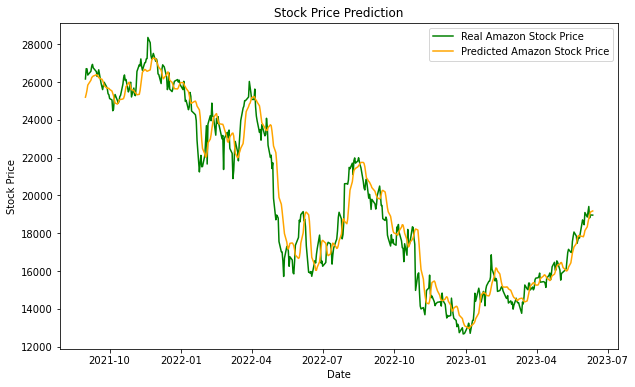

In [138]:
# new_data[['Open','Test_Predicted']].plot(figsize=(10,6))  #or
plt.figure(figsize=(10,6))
plt.plot(np.array(new_data.index),new_data.loc[:,'Open'],label="Real Amazon Stock Price",color= 'green')
plt.plot(np.array(new_data.index),new_data.loc[:,'Test_Predicted'],label="Predicted Amazon Stock Price",color= 'orange')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction")
plt.legend()
plt.show()

## Checking Error

In [96]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_preds))

15215.427785487933

In [97]:
math.sqrt(mean_squared_error(y_test,test_preds))

20362.187942195003

## Predicting Next 30 Days Prices (Currently working)

In [98]:
# len(test_data)

529

In [99]:
# x_input = test_data[449:].reshape(1,-1)
# x_input.shape

(1, 80)

In [103]:
# temp_input = list(x_input)
# temp_input = temp_input[0].tolist()
# temp_input
# x_input.reshape(-1)

In [125]:
# from numpy import array
# list_op = []
# n_steps = 80
# i=0
# while(i<30):
    
#     if(len(temp_input)>80):
        
#         x_input = np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input = x_input.reshape(1,-1)
#         x_input = x_input.reshape(1,n_steps,1)
        
#         y_predict = model.predict(x_input,verbose=0)
#         print("{} day output {}".format(i,y_predict))
#         temp_input.extend(y_predict[0].tolist())
#         temp_input = temp_input[1:]
        
#         list_op.extend(y_predict.tolist())
#         i=i+1
#     else:
#         x_input = x_input.reshape(1,n_steps,1)
#         y_predict = model.predict(x_input,verbose=0)
#         print(y_predict[0])
#         temp_input.extend(y_predict[0].tolist())
#         print(len(temp_input))
#         list_op.extend(y_predict.tolist())
#         i=i+1
# print(list_op)

0 day input [0.41415277 0.39803209 0.39645936 0.40314356 0.386171   0.39108583
 0.38361529 0.38839908 0.37227846 0.38099404 0.39704917 0.38964414
 0.38662971 0.38715397 0.38053533 0.36284197 0.38813695 0.38413955
 0.40071889 0.42719343 0.41815017 0.4163808  0.43151845 0.43138741
 0.41592209 0.42247519 0.41618422 0.41998502 0.4387269  0.4427243
 0.44364173 0.4465906  0.45419223 0.4334844  0.43486054 0.43381207
 0.43119083 0.4216888  0.44213449 0.4492774  0.4544543  0.43892349
 0.45170201 0.46854348 0.47876636 0.46074533 0.46159721 0.48204291
 0.47922507 0.4610074  0.43820264 0.45307816 0.45504411 0.4565513
 0.46159721 0.46448059 0.48164968 0.50085027 0.50825531 0.50163667
 0.50098136 0.52614525 0.53794085 0.54757392 0.53846506 0.52208231
 0.52915967 0.53754763 0.53368133 0.57516247 0.56913358 0.56415325
 0.59187285 0.58165003 0.59285583 0.60556886 0.57935645 0.58636827
 0.58597505 0.59329188 0.59329188 0.59329188]


ValueError: cannot reshape array of size 82 into shape (1,80,1)